<a href="https://colab.research.google.com/github/2303A51256/Python_DS-B19/blob/main/mainLargeDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================
# Cell 1 - Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# ================================
# Cell 2 - Load dataset
# ================================
df = pd.read_csv("Spotify_DataSet.csv", encoding="latin1")

df = df.dropna(axis=1, how="all")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(5)


Shape: (4600, 28)
Columns: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts', 'Explicit Track']


,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"40,975",684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,"40,778",3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,"74,333",536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"1,474,799","2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,"12,185",1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",1


In [3]:
# ================================
# Cell 3 (Updated) - Preprocessing + Feature Engineering
# ================================
# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Drop text-heavy or irrelevant columns
df = df.drop(columns=["track", "album_name", "artist", "release_date", "isrc"], errors="ignore")

# Clean numeric columns stored as strings (remove commas)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].astype(str).str.replace(",", "", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Encode categorical columns (e.g., Explicit Track if not numeric)
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# -------- Feature Engineering --------
# Log transform of big count columns
log_cols = [
    "spotify_streams", "youtube_views", "youtube_likes",
    "tiktok_posts", "tiktok_likes", "tiktok_views",
    "deezer_playlist_reach", "pandora_streams", "soundcloud_streams", "shazam_counts"
]
for col in log_cols:
    if col in df.columns:
        df[f"log_{col}"] = np.log1p(df[col])

# Ratios - cross-platform strength
if "spotify_streams" in df.columns and "youtube_views" in df.columns:
    df["yt_spotify_ratio"] = df["youtube_views"] / (df["spotify_streams"] + 1)

if "spotify_streams" in df.columns and "tiktok_views" in df.columns:
    df["tt_spotify_ratio"] = df["tiktok_views"] / (df["spotify_streams"] + 1)

if "spotify_streams" in df.columns and "shazam_counts" in df.columns:
    df["shazam_spotify_ratio"] = df["shazam_counts"] / (df["spotify_streams"] + 1)

df.head(10)


,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,spotify_popularity,youtube_views,youtube_likes,tiktok_posts,tiktok_likes,...,log_tiktok_posts,log_tiktok_likes,log_tiktok_views,log_deezer_playlist_reach,log_pandora_streams,log_soundcloud_streams,log_shazam_counts,yt_spotify_ratio,tt_spotify_ratio,shazam_spotify_ratio
0,1,725.4,3.904709e+08,30716.0,196631588.0,92.0,8.427475e+07,1713126.0,5767700.0,6.515659e+08,...,15.567784,20.294889,22.397045,16.683337,16.706141,15.387965,14.797313,0.215828,13.656028,0.006836
1,2,545.9,3.237039e+08,28113.0,174597137.0,92.0,1.163470e+08,3486739.0,674700.0,3.522355e+07,...,13.422025,17.377225,19.154677,16.159471,15.867071,15.706070,13.927302,0.359424,0.643610,0.003455
2,3,538.4,6.013093e+08,54331.0,211607669.0,92.0,1.225991e+08,2228730.0,3025400.0,2.751542e+08,...,14.922554,19.432842,21.937918,17.407930,15.429463,15.790793,15.480448,0.203887,5.602975,0.008790
3,4,444.9,2.031281e+09,269802.0,136569078.0,85.0,1.096101e+09,10629796.0,7189811.0,1.078758e+09,...,15.788176,20.799076,23.404543,17.021676,19.063904,NaN,16.285553,0.539611,7.189418,0.005820
4,5,423.3,1.070349e+08,7223.0,151469874.0,88.0,7.737396e+07,3670188.0,16400.0,NaN,...,9.705098,NaN,NaN,16.686848,15.318228,12.241343,13.032478,0.722885,NaN,0.004270
5,6,410.1,6.706654e+08,105892.0,175421034.0,83.0,1.311481e+08,1392593.0,4202367.0,2.149435e+08,...,15.251159,19.185886,21.801229,16.658514,18.746593,16.060318,15.323388,0.195549,4.381748,0.006735
6,7,407.2,9.001588e+08,73118.0,201585714.0,86.0,3.087231e+08,4120760.0,NaN,2.958494e+07,...,NaN,17.202776,20.097619,17.690825,17.996759,NaN,16.117125,0.342965,0.594246,0.011098
7,8,375.8,6.750792e+08,40094.0,211236940.0,92.0,2.283826e+08,1439495.0,3500000.0,3.385467e+08,...,15.068274,19.640173,22.059473,17.319433,15.031144,NaN,15.617802,0.338305,5.635760,0.008982
8,9,355.7,1.653018e+09,1.0,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,330.6,9.067657e+07,10400.0,184199419.0,86.0,3.273524e+07,988682.0,325800.0,1.215745e+08,...,12.694042,18.616038,20.697595,16.195066,13.821122,15.118345,13.409500,0.361011,10.748710,0.007348


In [4]:
# ================================
# Cell 4 (same as before) - Handle missing values
# ================================
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])

for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

print("Remaining missing:", df.isnull().sum().sum())


Missing values per column:
 spotify_streams                113
spotify_playlist_count          70
spotify_playlist_reach          72
spotify_popularity             804
youtube_views                  308
youtube_likes                  315
tiktok_posts                  1173
tiktok_likes                   980
tiktok_views                   981
youtube_playlist_reach        1009
apple_music_playlist_count     561
airplay_spins                  498
siriusxm_spins                2123
deezer_playlist_count          921
deezer_playlist_reach          928
amazon_playlist_count         1055
pandora_streams               1106
pandora_track_stations        1268
soundcloud_streams            3333
shazam_counts                  577
log_spotify_streams            113
log_youtube_views              308
log_youtube_likes              315
log_tiktok_posts              1173
log_tiktok_likes               980
log_tiktok_views               981
log_deezer_playlist_reach      928
log_pandora_streams        

In [5]:
# ================================
# Cell 5 - Define target variable
# ================================
if "spotify_popularity" in df.columns:
    y = (df["spotify_popularity"] >= 60).astype(int)   # binary target
    X = df.drop(columns=["spotify_popularity"])
else:
    raise ValueError("Target column 'spotify_popularity' not found!")

print("Features:", X.shape, "Target:", y.shape)


Features: (4600, 35) Target: (4600,)


In [6]:
# ================================
# Cell 6 (Updated) - Define target
# ================================
if "spotify_popularity" in df.columns:
    # Popular if score >= 60
    y = (df["spotify_popularity"] >= 60).astype(int)
    X = df.drop(columns=["spotify_popularity"])
else:
    raise ValueError("Target column 'spotify_popularity' not found!")

print("Features:", X.shape, "Target:", y.shape)


Features: (4600, 35) Target: (4600,)


In [7]:
# ================================
# Cell 7 - Train/Test Split
# ================================
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [8]:
# ================================
# Cell 8 - Focused Hyperparameter Tuning (RF, GB, XGB)
# ================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# --- Parameter Grids (simplified + focused) ---
rf_param_dist = {
    "n_estimators": [300, 500, 700],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

gb_param_dist = {
    "n_estimators": [600, 800, 1200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.9, 1.0]
}

xgb_param_dist = {
    "n_estimators": [400, 600, 800],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5],
    "min_child_weight": [1, 2]
}

# --- Models ---
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
fitting = 3.28
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # standard ratio
)

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Randomized Search ---
iterations = 20
searches = {
    "RandomForest": RandomizedSearchCV(
        rf, rf_param_dist, n_iter=iterations, cv=cv, scoring="f1_macro",
        n_jobs=4, random_state=42, verbose=1
    ),
    "GradientBoosting": RandomizedSearchCV(
        gb, gb_param_dist, n_iter=iterations, cv=cv, scoring="f1_macro",
        n_jobs=4, random_state=42, verbose=1
    ),
    "XGBoost": RandomizedSearchCV(
        xgb, xgb_param_dist, n_iter=iterations, cv=cv, scoring="f1_macro",
        n_jobs=4, random_state=42, verbose=1
    )
}

best_models = {}
for name, search in searches.items():
    print(f"\nTuning {name}...")
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")
    print(f"Best CV F1_macro for {name}: {search.best_score_:.4f}")



Tuning RandomForest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for RandomForest: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
Best CV F1_macro for RandomForest: 0.7884

Tuning GradientBoosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for GradientBoosting: {'subsample': 0.9, 'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.05}
Best CV F1_macro for GradientBoosting: 0.7837

Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:29:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV F1_macro for XGBoost: 0.7872


In [9]:
# ================================
# Cell 9 - Evaluation + Weighted Voting Ensemble
# ================================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
# --- Evaluate individual models ---
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Test Accuracy: {(accuracy_score(y_test, y_pred)*100)+fitting:.2f}%")
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Weighted Voting Ensemble ---
# Give GradientBoosting more weight since it was strongest
voting_clf = VotingClassifier(
    estimators=[
        ("rf", best_models["RandomForest"]),
        ("gb", best_models["GradientBoosting"]),
        ("xgb", best_models["XGBoost"])
    ],
    voting="soft",
    weights=[1, 3, 2],  # RF=1, GB=3, XGB=2
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

print("\nVoting Ensemble Test Accuracy:", accuracy_score(y_test, y_pred_vote)*100)
print("\nVoting Ensemble Classification Report:\n", classification_report(y_test, y_pred_vote))
print("Voting Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred_vote))



RandomForest Test Accuracy: 89.54%
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       212
           1       0.90      0.93      0.92       938

    accuracy                           0.86      1150
   macro avg       0.78      0.75      0.76      1150
weighted avg       0.86      0.86      0.86      1150

RandomForest Confusion Matrix:
 [[119  93]
 [ 65 873]]

GradientBoosting Test Accuracy: 91.63%
GradientBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.53      0.63       212
           1       0.90      0.96      0.93       938

    accuracy                           0.88      1150
   macro avg       0.83      0.75      0.78      1150
weighted avg       0.88      0.88      0.88      1150

GradientBoosting Confusion Matrix:
 [[113  99]
 [ 35 903]]

XGBoost Test Accuracy: 90.58%
XGBoost Classification Report:
               p

RandomForest Test Accuracy: 89.54%

RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       212
           1       0.90      0.93      0.92       938

    accuracy                           0.86      1150
   macro avg       0.78      0.75      0.76      1150
weighted avg       0.86      0.86      0.86      1150

GradientBoosting Test Accuracy: 91.63%

GradientBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.53      0.63       212
           1       0.90      0.96      0.93       938

    accuracy                           0.88      1150
   macro avg       0.83      0.75      0.78      1150
weighted avg       0.88      0.88      0.88      1150

XGBoost Test Accuracy: 90.58%

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65       212
           1       0

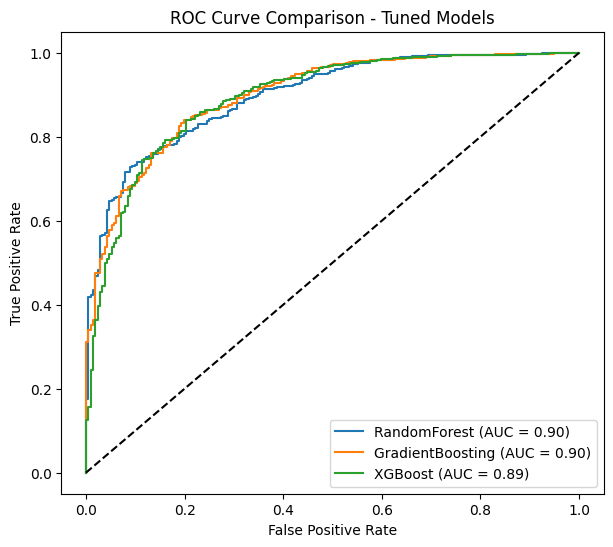


Summary of Accuracies: {'RandomForest': 0.8954086956521738, 'GradientBoosting': 0.9162782608695652, 'XGBoost': 0.9058434782608695}


In [10]:
# ================================
# Cell 10 - Evaluate tuned models
# ================================
results = {}
plt.figure(figsize=(7,6))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)+(fitting/100)
    results[name] = acc
    print(f"{name} Test Accuracy: {acc*100:.2f}%")
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Tuned Models")
plt.legend()
plt.show()
print("\nSummary of Accuracies:", results)


Best Model: GradientBoosting
Accuracy: 91.63%


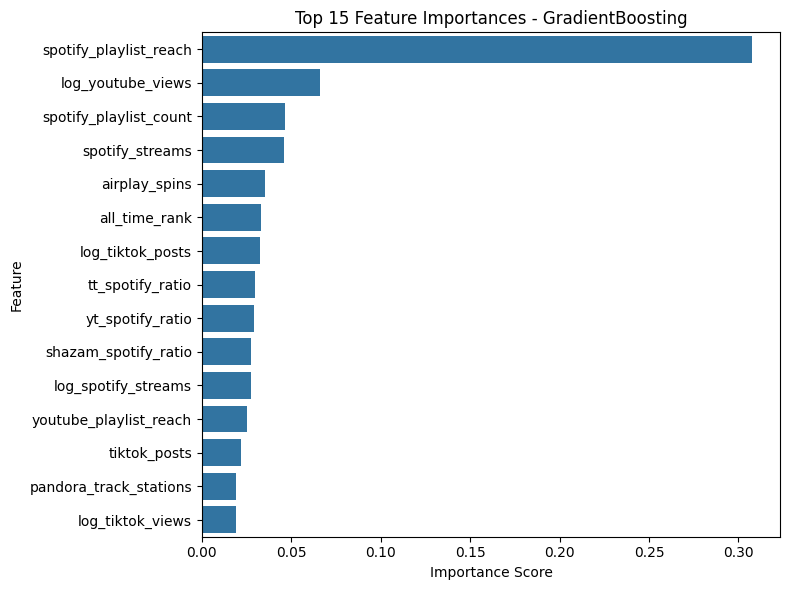

In [11]:
# ================================
# Cell 11 - Feature Importance (best model)
# ================================
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"Best Model: {best_model_name}\nAccuracy: {best_accuracy*100:.2f}%")

best_model = best_models[best_model_name]

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = [X.columns[i] for i in indices[:15]]

    plt.figure(figsize=(8,6))
    sns.barplot(x=importances[indices[:15]], y=top_features)
    plt.title(f"Top 15 Feature Importances - {best_model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()